# Music Recommendation System

### Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

import matplotlib.pyplot as plt

### Load Dataset

In [2]:
DATA_PATH = "dataset.csv"
df = pd.read_csv(DATA_PATH)
print("Dataset loaded:", df.shape)
df.head()

Dataset loaded: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### Prepare Numeric Features

In [3]:
NUMERIC_COLS = [
    "popularity", "duration_ms", "explicit", "danceability", "energy", "key",
    "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "time_signature"
]

# Ensure explicit flag is numeric
df["explicit"] = df["explicit"].astype(int)

# Remove duplicate songs by track name (keep first occurrence)
df = df.drop_duplicates(subset="track_name", keep="first").reset_index(drop=True)
print(f"Dataset shape after removing duplicates by track_name: {df.shape}")

# Fill missing numeric values
for col in NUMERIC_COLS:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# Feature matrix
X = df[NUMERIC_COLS].astype(float).values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)


Dataset shape after removing duplicates by track_name: (73609, 21)
Feature matrix shape: (73609, 15)


### Build Autoencoder

In [4]:
EMBEDDING_DIM = 128
INPUT_DIM = X_scaled.shape[1]

# Input layer
inputs = layers.Input(shape=(INPUT_DIM,), name="input")

# Encoder
x = layers.Dense(32, activation="relu")(inputs)
x = layers.Dropout(0.05)(x)  # smaller dropout for numeric features
embedding = layers.Dense(EMBEDDING_DIM, activation="linear", name="embedding")(x)

# Decoder
x = layers.Dense(32, activation="relu")(embedding)
outputs = layers.Dense(INPUT_DIM, activation="linear", name="reconstruction")(x)

# Models
autoencoder = models.Model(inputs, outputs, name="autoencoder")
encoder = models.Model(inputs, embedding, name="encoder")

# Compile
autoencoder.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss="mse"
)

autoencoder.summary()

2025-11-26 16:40:51.453576: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-11-26 16:40:51.453644: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-11-26 16:40:51.453652: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-11-26 16:40:51.453698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-26 16:40:51.453723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15)]              0         
                                                                 
 dense (Dense)               (None, 32)                512       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 embedding (Dense)           (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 reconstruction (Dense)      (None, 15)                495       
                                                                 
Total params: 9359 (36.56 KB)
Trainable params: 9359 (3

### Train Autoencoder

Epoch 1/100


2025-11-26 16:40:51.942520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-26 16:40:51.976473: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


259/259 - 2s - loss: 0.9233 - val_loss: 0.5346 - 2s/epoch - 7ms/step
Epoch 2/100
259/259 - 1s - loss: 0.3916 - val_loss: 0.2681 - 1s/epoch - 4ms/step
Epoch 3/100
259/259 - 1s - loss: 0.2236 - val_loss: 0.1540 - 1s/epoch - 4ms/step
Epoch 4/100
259/259 - 1s - loss: 0.1400 - val_loss: 0.0899 - 1s/epoch - 4ms/step
Epoch 5/100
259/259 - 1s - loss: 0.0933 - val_loss: 0.0513 - 1s/epoch - 4ms/step
Epoch 6/100
259/259 - 1s - loss: 0.0655 - val_loss: 0.0281 - 989ms/epoch - 4ms/step
Epoch 7/100
259/259 - 1s - loss: 0.0500 - val_loss: 0.0154 - 988ms/epoch - 4ms/step
Epoch 8/100
259/259 - 1s - loss: 0.0422 - val_loss: 0.0092 - 984ms/epoch - 4ms/step
Epoch 9/100
259/259 - 1s - loss: 0.0376 - val_loss: 0.0059 - 985ms/epoch - 4ms/step
Epoch 10/100
259/259 - 1s - loss: 0.0348 - val_loss: 0.0041 - 994ms/epoch - 4ms/step
Epoch 11/100
259/259 - 1s - loss: 0.0330 - val_loss: 0.0031 - 988ms/epoch - 4ms/step
Epoch 12/100
259/259 - 1s - loss: 0.0318 - val_loss: 0.0025 - 985ms/epoch - 4ms/step
Epoch 13/100
259

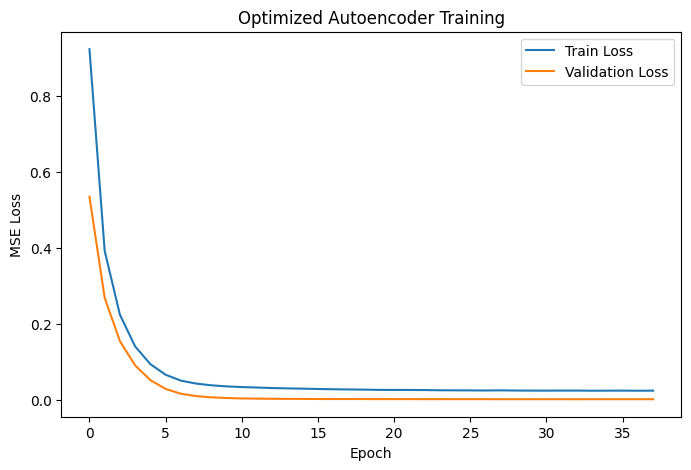

In [5]:
EPOCHS = 100
BATCH_SIZE = 256

# Early stopping to prevent overfitting
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Optional: clip extreme features
X_scaled_clipped = np.clip(X_scaled, -5, 5)

# Train
history = autoencoder.fit(
    X_scaled_clipped, X_scaled_clipped,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)

# Plot training curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Optimized Autoencoder Training')
plt.legend()
plt.show()

### Generate Embeddings

144/144 [==============================] - 0s 1ms/step
Embedding shape: (73609, 128)


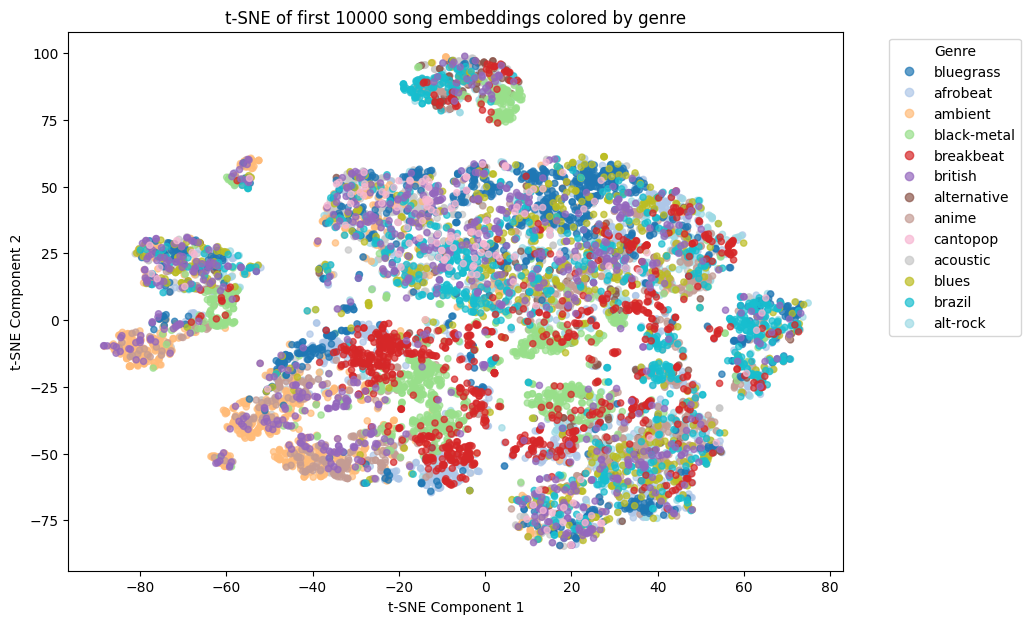

In [6]:
embeddings = encoder.predict(X_scaled, batch_size=512)
print("Embedding shape:", embeddings.shape)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(embeddings[:10000])

# Map first 10000 tracks to their genres
genres = df["track_genre"].iloc[:10000].values
unique_genres = list(set(genres))
genre_to_color = {genre: idx for idx, genre in enumerate(unique_genres)}
colors = [genre_to_color[g] for g in genres]

plt.figure(figsize=(10,7))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=colors, cmap="tab20", s=20, alpha=0.7)
plt.title("t-SNE of first 10000 song embeddings colored by genre")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Add legend
handles, _ = scatter.legend_elements(num=len(unique_genres))
plt.legend(handles, unique_genres, bbox_to_anchor=(1.05, 1), loc='upper left', title="Genre")
plt.show()

### Cosing Similarity Index

In [7]:
nn = NearestNeighbors(n_neighbors=11, metric="cosine")
nn.fit(embeddings)
print("Nearest-neighbor index built.")

Nearest-neighbor index built.


### Recommendation Function

In [8]:
def recommend_by_track_id(track_id, k=10):
    matches = df.index[df["track_id"] == track_id].tolist()
    if not matches:
        raise ValueError("Track ID not found:", track_id)
    
    idx = matches[0]
    vec = embeddings[idx].reshape(1, -1)
    
    dists, idxs = nn.kneighbors(vec, n_neighbors=k+1)
    
    rec_indices = [i for i in idxs[0] if i != idx][:k]
    recs = df.iloc[rec_indices][["track_id", "artists", "track_name", "track_genre"]].copy()
    recs["cosine_distance"] = dists[0][1:1+len(rec_indices)]
    
    return recs

### Testing the Function

In [9]:
sample_idx = random.randint(0, len(df) - 1)
sample_track = df.loc[sample_idx]

print("Sample track:")
display(sample_track[["track_id", "artists", "track_name", "track_genre"]])

print("\nRecommended tracks:")
display(recommend_by_track_id(sample_track["track_id"], k=10))

Sample track:


track_id       017PF4Q3l4DBUiWoXk4OWT
artists                      Dua Lipa
track_name             Break My Heart
track_genre                     dance
Name: 16693, dtype: object


Recommended tracks:


,track_id,artists,track_name,track_genre,cosine_distance
220,5MYPzdIWgx3pMLRGlq2fVq,Zack Tabudlo,Asan Ka Na Ba,acoustic,0.029545
45729,6I2tqFhk8tq69iursYxuxd,SEVENTEEN,HOT,k-pop,0.034117
27539,0BD9boQC7jUTWkAoib4Z0d,Soolking;Dadju,Meleğim,french,0.037721
16575,6h5PAsRni4IRlxWr6uDPTP,Axwell /\ Ingrosso,More Than You Know,dance,0.042350
57390,0ycG3FRZqK3pUGWhQCPgAN,Dannic;Parah Dice,Get Over You,progressive-house,0.047340
16503,2oejEp50ZzPuQTQ6v54Evp,The Chainsmokers;Bebe Rexha,Call You Mine,dance,0.049544
23848,7MmG8p0F9N3C4AXdK6o6Eb,Calvin Harris;Ellie Goulding,Outside (feat. Ellie Goulding),electro,0.050668
45751,0Q5VnK2DYzRyfqQRJuUtvi,IVE,LOVE DIVE,k-pop,0.052311
39328,0MWiSBKm8Avs8iDIxcertp,Anne-Marie;Little Mix,Kiss My (Uh Oh),house,0.054963
45732,13MF2TYuyfITClL1R2ei6e,BLACKPINK,BOOMBAYAH,k-pop,0.055505


### Evaluate Autoencoder

In [10]:
# Reconstruction Error
reconstructions = autoencoder.predict(X_scaled, batch_size=512)
mse_per_track = np.mean((X_scaled - reconstructions)**2, axis=1)
mean_mse = np.mean(mse_per_track)
max_mse = np.max(mse_per_track)

print(f"Mean reconstruction MSE: {mean_mse:.4f}")
print(f"Max reconstruction MSE: {max_mse:.4f}")

# Genre Hit Rate Function
def genre_hit_rate(track_id, k=10):
    seed_genre = df.loc[df['track_id'] == track_id, 'track_genre'].values[0]
    recs = recommend_by_track_id(track_id, k=k)
    hit_rate = (recs['track_genre'] == seed_genre).mean()
    return hit_rate

# Evaluate hit rate across 100 random tracks
random_indices = np.random.choice(len(df), size=100, replace=False)
hit_rates = [genre_hit_rate(df.iloc[i]['track_id']) for i in random_indices]
avg_hit_rate = np.mean(hit_rates)

print(f"Average genre hit rate (top 10 recommendations): {avg_hit_rate:.2%}")

# Example Recommendations for Inspection
for idx in random_indices[:3]:
    sample_track = df.iloc[idx]
    print("\nSeed Track:")
    display(sample_track[['track_id','artists','track_name','track_genre']])
    print("Top Recommendations:")
    display(recommend_by_track_id(sample_track['track_id'], k=10))


144/144 [==============================] - 0s 2ms/step
Mean reconstruction MSE: 0.0009
Max reconstruction MSE: 0.1433
Average genre hit rate (top 10 recommendations): 12.90%

Seed Track:


track_id       1cA152V3HczMxJ3oP4ZhVK
artists               Dither;MC Focus
track_name        Tools of Demolition
track_genre                       idm
Name: 39550, dtype: object

Top Recommendations:


,track_id,artists,track_name,track_genre,cosine_distance
36691,3Rlvtc0ehS8B8gF9ab7qZq,Kenai;Scarra,Give U Some,hardstyle,0.027266
23013,1HCfu0muPAsWAknx1YleI2,Carbin;hayve;Emily Makis,Murderer,dub,0.039179
39946,40bEjLxDNU1ucfvH4pX1Wp,Dither,Make It Work - Radio Edit,idm,0.040858
39548,214VcdApAmkrGSVcinjwjv,Dither,Make It Work,idm,0.041040
34347,6jsil8WFlrsRf3mhKhfWAB,Nosferatu;Tha Playah,Beginning Of Time,happy,0.047668
22246,25XOcOj9UIdPHf6QxsNsGp,Calyx & TeeBee,Ghostwriter,drum-and-bass,0.049155
34845,2Uzej6maMDJF5VABNeAP8G,The Stunned Guys;DJ Paul;Wild Motherfuckers,Thrillseeka - Wild Motherfuckers Remix,happy,0.051846
36833,6q92MBGsZZEYvPtovjPKc5,Zany;Ransom;MC Dash,Tijd om te Zagen [SSZD Kingsday 2017 Zany & Fr...,hardstyle,0.052568
39491,2n33B7iUh4oRF37trcSq3M,Dither;Da Mouth of Madness,Veilinghallen,idm,0.056195
36934,76PdGNIMVnT5ShWbG115ME,Mortalis,Lead Us,hardstyle,0.066203



Seed Track:


track_id       7J40nnJbQyreKOc3BTiuYD
artists                The Pirouettes
track_name             Tu parles trop
track_genre                 synth-pop
Name: 69537, dtype: object

Top Recommendations:


,track_id,artists,track_name,track_genre,cosine_distance
64319,4p9nwYUhmGYmfIDYCmAdzQ,Susan Egan;Cheryl Freeman;LaChanze;Vaneese Tho...,"I Won't Say (I'm In Love) - From ""Hercules""",show-tunes,0.070797
845,5Z01kGFWQcQA3XBRxjAzAJ,Andrew Foy;Renee Foy;Stephan Baulig,Afterglow - Stephan Baulig Remix,acoustic,0.072617
27715,1liRNanPls9Ri9LwcbMw1Z,Deluxe,Tududu,french,0.075804
69064,201y8N0jrbsN8WAnsCeWh7,Melissa Horn,Sen en tid tillbaka,swedish,0.077644
43528,2B83qbOwcgswUOMqJzacNm,LOZAREENA,星の王子さま,j-dance,0.081184
64489,6XX2Y8We4GuptxiFMcG8gY,Carmen Cusack;Bright Star Original Broadway En...,Sun Is Gonna Shine - Single Version,show-tunes,0.084117
69626,3GhKBlpYJLpel5wykSrXXK,Sparks;Adam Driver;Marion Cotillard;Simon Helberg,So May We Start (feat. Simon Helberg) - Versio...,synth-pop,0.089526
69509,7DIn6SjWo3e5BPLIsqPKjG,Sparks,I Wish I Looked a Little Better,synth-pop,0.089783
49506,294jS0EVBue6WSgF38SCVl,Jody Chiang;施文彬,你我相逢,mandopop,0.091933
6337,1fCSnotiP3cen8C6uyCKbd,Nickel Creek,Young,bluegrass,0.094956



Seed Track:


track_id       0elHZFtNBDKLQtV6Q0TMP8
artists                 Planetshakers
track_name      Come Right Now - Live
track_genre               world-music
Name: 73415, dtype: object

Top Recommendations:


,track_id,artists,track_name,track_genre,cosine_distance
67583,6bUJiOxM6Qczq3ULSEUaFC,La Oreja de Van Gogh,La Niña Que Llora en Tus Fiestas - Directo Mexico,spanish,0.022211
72865,3cuGik6VFOpDNWW4yFqnl9,Hillsong Young & Free;TAYA,Wake (Live),world-music,0.022972
59190,5OdPE6LOPmRWukqVslSQal,MORADA,Dia e Noite - Ao Vivo,reggae,0.024015
65611,5U4j82rLbxIin4KwsKV4gu,Los Fabulosos Cadillacs,El Genio Del Dub - Versión Remasterizada (Live),ska,0.025576
56984,6Pyb3IExfdj8CSjQeN3455,Ruben de Ronde;Zack Evans,Lean On Me (ASOT 1090) - Zack Evans Remix,progressive-house,0.026803
32320,6OaI0ZpuuHfTYGBCUkXTCk,Kemuel,Não Valeria,groove,0.027008
29859,3PWzBVskGNV5YRThi0Sxh8,Bishop Larry Trotter;Sweet Holy Spirit,The Lord Is Blessing Me,gospel,0.030861
35926,2r6SssBYtX3BUaFHf3pGA5,Los Prisioneros,¿Por Que No Se Van? (En Vivo),hardcore,0.031495
32286,1XoqRWIkL2Q0DJ7PGA8cjx,Trazendo a Arca,Toque no Altar - Ao Vivo,groove,0.034117
37623,23EAtpCyQuPMiKWFOt5XPM,Carajo,Luna Herida - En Vivo,heavy-metal,0.034761
